<a href="https://colab.research.google.com/github/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/blob/master/Week%2003%20Generative%20Modeling%20II/generative-mnist/generative_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

# Clone remote

In [1]:
import os
from pathlib import Path

URL = "https://github.com/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit"
NBDIR = "Week 03 Generative Modeling II/generative-mnist"

def clone(url, dest=".", branch="master", reloc=True):
  """
  Clone remote branch from url into dest
  branch not provided: clone all branches
  reloc is True: relocate to repository
  """

  url = url.strip(" /")
  repo = Path(dest, os.path.basename(url)).resolve()

  # dest must not be inside existing repository
  is_out = !git -C "$dest" rev-parse
  if not is_out: # inside repository
    raise ValueError("Can't clone into existing repository")
  
  # Clone
  p = repo.as_posix()
  if branch: # specific branch
    !git clone --single-branch --branch "$branch" "$url" "$p"
  else: # all branches
    !git clone "$url" "$p"
  
  # Relocate
  if reloc:
    os.chdir(repo)

  return repo.as_posix()
  
REPO = clone(URL)
%run .Importable.ipynb
sys.path.append(REPO)
%cd "$NBDIR"

Cloning into '/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 615 (delta 86), reused 0 (delta 0), pack-reused 454
Receiving objects: 100% (615/615), 2.79 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (306/306), done.


/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/Week 03 Generative Modeling II/generative-mnist


## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal
from Packages.MNIST import load_images, load_labels

importing Jupyter notebook from /content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/Packages/MNIST.ipynb


Now load in the training set and test set. The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [3]:
urls = {"train-images-idx3-ubyte.gz": "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte.gz": "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz": "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz": "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}

## Load the training set
train_data = load_images(urls["train-images-idx3-ubyte.gz"])
train_labels = load_labels(urls["train-labels-idx1-ubyte.gz"])
print("Train:\t{images}\t{labels}".format(images=train_data.shape, labels=train_labels.shape))

## Load the testing set
test_data = load_images(urls["t10k-images-idx3-ubyte.gz"])
test_labels = load_labels(urls["t10k-labels-idx1-ubyte.gz"])
print("Test:\t{images}\t{labels}".format(images=test_data.shape, labels=test_labels.shape))

Train:	(60000, 784)	(60000,)
Test:	(10000, 784)	(10000,)


The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [0]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

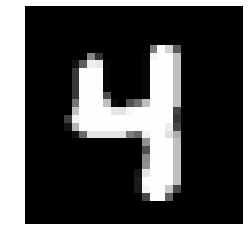

In [5]:
displaychar(train_data[58])

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [0]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    ### Your code goes here
    ###
    for label in range(k):
      s = (y == label) # subset of y
      xs = x[s, :] # subset of x
      mu[label] = np.mean(xs, axis=0)
      sigma[label] = np.cov(xs, rowvar=False, bias=True)
      pi[label] = sum(s)/len(y)

    # Halt and return parameters
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

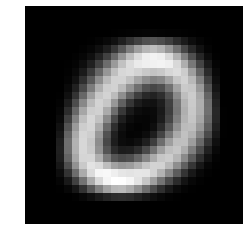

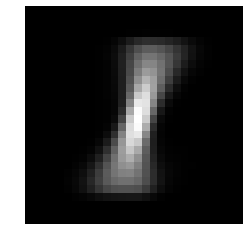

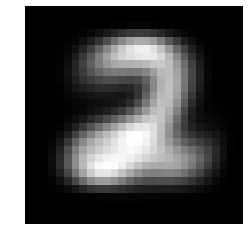

In [7]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [0]:
def predict(obs, mu, sigma, pi):
  """
  Predict label of observation
  """
  scores = []
  for m, s, p in zip(mu, sigma, pi):
    score = np.log(p) + multivariate_normal.logpdf(obs, mean=m, cov=s)
    scores.append(score)
  return np.argmax(scores)

def error(mu, sigma, pi, x, y, reg=0):
  """
  Compute error (%) produced by model on x, y
  reg: regularization constant c
  """
  # Regularize sigma
  diag = sigma.shape[1]
  sigma[:, range(diag), range(diag)] += reg
  
  predictions = np.apply_along_axis(predict, 1, x, mu, sigma, pi)
  failures = np.sum(predictions != y)
  return failures/len(y)

#error(mu, sigma, pi, test_data, test_labels, reg=1)

def test_model(mu, sigma, pi, test_data, test_labels, reg=0):
  # Regularize
  diag = sigma.shape[1]
  sigma[:, range(diag), range(diag)] += reg
  # Compute log Pr(label|image) for each [test image,label] pair.
  k = 10 # labels 0,1,...,k-1
  score = np.zeros((len(test_labels),k))
  for label in range(k):
      rv = multivariate_normal(mean=mu[label], cov=sigma[label])
      score[:,label] = np.log(pi[label]) + rv.logpdf(test_data)
  predictions = np.argmax(score, axis=1)
  # Finally, tally up score
  errors = np.sum(predictions != test_labels)
  print("Your model makes " + str(errors) + " errors out of 10000")
  return errors/len(test_labels)

test_model(mu, sigma, pi, test_data, test_labels, reg=1)

In [13]:
nsamples = 3
x = np.linspace(-1,1,nsamples)
y=np.linspace(-2,2,nsamples)
rv=multivariate_normal(np.array([0,0]),np.array([[1,0],[0,4]]))
a=np.arange(10).reshape(5,2)
rv.logpdf(a)

array([ -2.65602425,  -5.65602425, -13.65602425, -26.65602425,
       -44.65602425])

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?